## The purpose of this notebook is to create a Machine Learning Model to determine what the breed of a dog is given a picture of it.

## This is from Kaggle's dog breed identification competition.

## Get our workspace ready

In [1]:
import numpy as np

In [ ]:
# !unzip "/content/drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "/content/drive/MyDrive/Dog Vision"

In [5]:
!pip install tensorflow==2.16.1 tensorflow-hub keras==3.0.0 # Fixes "Only instances of `keras.Layer` can be added to a Sequential model." Error

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.9/589.9 MB 648.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.1/997.1 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 111.4 MB

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
print("tensorflow version", tf.__version__)
print("tensorflow hub version", hub.__version__)

# Check if GPU is available
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

tensorflow version 2.16.1
tensorflow hub version 0.16.1
GPU not available


## Turning our data into Tensors

In [3]:
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


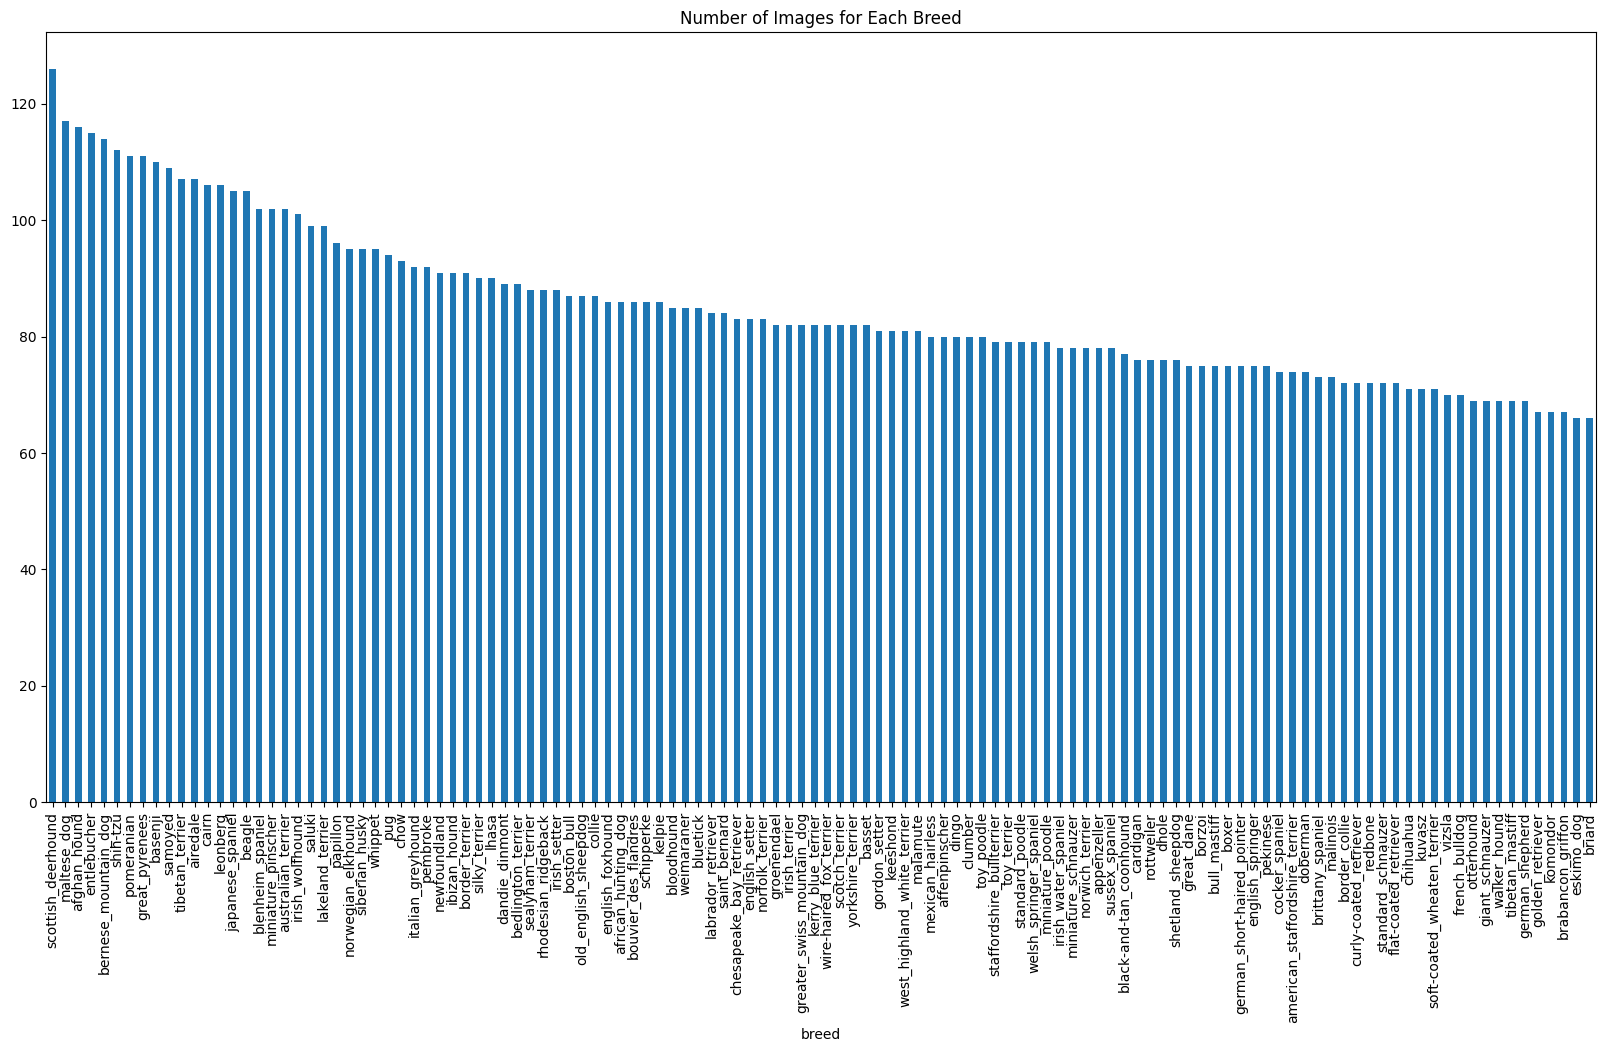

In [4]:
# How many images of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10), title="Number of Images for Each Breed");

In [5]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [6]:
labels_csv["breed"].value_counts().median()

82.0

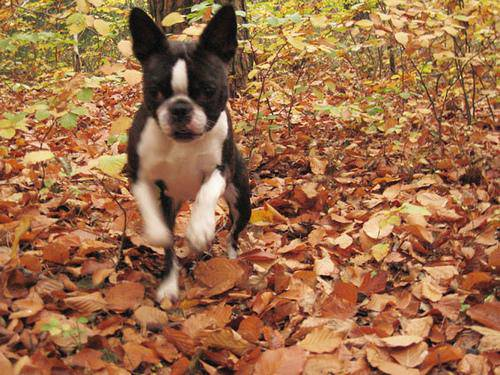

In [7]:
# Image example
from IPython.display import Image
Image("/content/drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

### Getting images and their labels

In [8]:
# Create pathnames from image ID's
filenames = ["/content/drive/MyDrive/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

filenames[:10]

['/content/drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [9]:
# Check wether number of filenames matches number of actual image files
import os
if len(os.listdir("/content/drive/MyDrive/Dog Vision/train/")) == len(filenames):
  print("Filenames match actual amount of files!")
else:
  print("Filenames do not match actual amount of files, check the")

Filenames match actual amount of files!


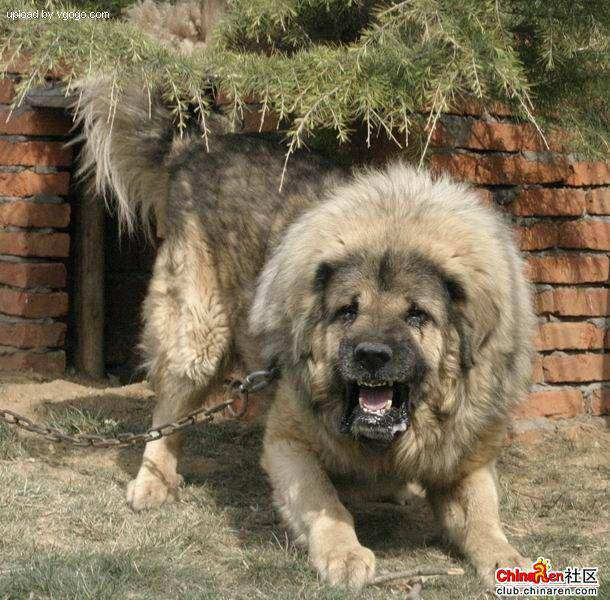

In [10]:
# One more check
Image(filenames[9000])

Prepare Labels

In [11]:
labels = labels_csv["breed"].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [12]:
# Check to see that labels and filenames are equal

if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames")

Number of labels matches number of filenames!


In [13]:
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [14]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [15]:
# Turn every label into boolean array

boolean_labels = [label == np.array(unique_breeds) for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [16]:
len(boolean_labels)

10222

# Creating a validation set

In [17]:
X = filenames
y = boolean_labels

#### We will start off with ~1000 images & increase as needed

In [18]:
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}
NUM_IMAGES

1000

In [19]:
from sklearn.model_selection import train_test_split

# Split them into training and validation fo total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [20]:
X_train[:5], y_train[:2]

(['/content/drive/MyDrive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/drive/MyDrive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  '/content/drive/MyDrive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  '/content/drive/MyDrive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  '/content/drive/MyDrive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         Fals

# Preprocessing Images

To prepeocess our images into Tensors, we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable
3. Turn our image into Tensors
4. Resize the image to be a shape of (224, 224)
5. Return the modified image

In [21]:
# Convert image to numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [22]:
# Turn image into tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

In [23]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes in an image file path and turns it into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turning our data into batches

In [24]:
# Create a simple functions to return a tuple
def get_image_label(image_path, label):
  """
  Takes an image file path name and the assosciated label, processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

We can now turn our data into tuples of Tensors in the from (image, label), let's make a function to turn all of our data, (x & y), into batches.

In [25]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch


In [26]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [27]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

In [28]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [29]:
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels)

(32, 32)

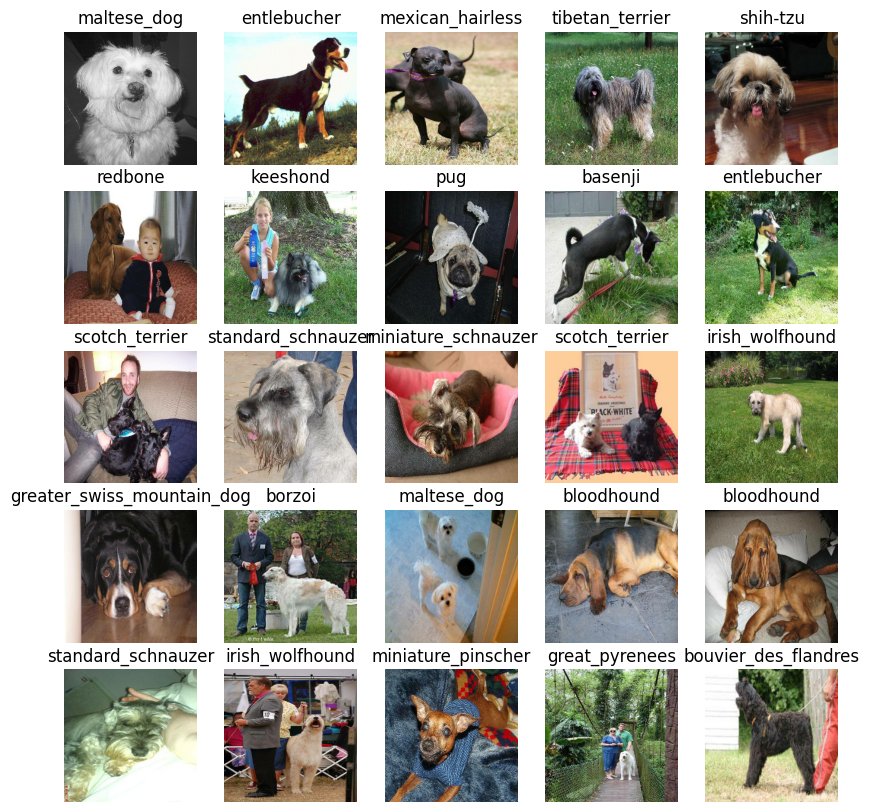

In [30]:
show_25_images(train_images, train_labels)

## Building a model

In [31]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Set up output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Set up model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [32]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [39]:
!pip install tensorflow==2.16.1 tensorflow-hub keras==3.0.0 # Fixes "Only instances of `keras.Layer` can be added to a Sequential model." Error

  Using cached tensorflow-2.16.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.3 kB)
  Using cached ml_dtypes-0.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached protobuf-4.25.8-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.9/589.9 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.1/997.1 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 28.4 MB/s eta 0:00:00
   

In [33]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <tensorflow_hub.keras_layer.KerasLayer object at 0x7bf0144e6150> (of type <class 'tensorflow_hub.keras_layer.KerasLayer'>)

In [ ]:
outputs = np.ones(shape=(1, 1, 1280))
outputs

## Creating Callbacks

### TensorBoard CallBack

In [ ]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard Logs
  logdir = os.path.join("drive/My Drive/Dog Vision/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping CallBack

In [ ]:
# Create early stopping callback
early_stopping= tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                       patience=3)

## Training a model

Our first model is only going to train on 1000 images, to make sure everything is going smoothly first.

In [ ]:
NUM_EPCOHS = 100 #@param {type:"slider", min:10, max:100, step:10}

Create a function which trains a model.

* Create a model using create_model().
* Setup a TensorBoard callback using create_tensorboard_callback() (we do this here so it creates a log directory of the current date and time).
* Call the fit() function on our model passing it the training data, validatation data, number of epochs to train for and the callbacks we'd like to use.
* Return the fitted model.

In [ ]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard sepecific log directory
  # This log directory is a "subdirectory" of the normal TensorBoard log directory
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPCOHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])

  # return the fitted model

  return model

In [ ]:
# Fit the model to the data
model = train_model()

### Checking the tensorboard logs

In [ ]:
%tensorboard --logdir drive/My\ Drive/Dog\ Vision/logs

## Making and evaluating predictions using a trained model

In [ ]:
# Make preictions on the validation data

predictions = model.predict(val_data, verbose=1)
predictions

In [ ]:
predictions.shape

In [ ]:
len(unique_breeds)

In [ ]:
len(y_val)

In [ ]:
# First prediction
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {unique_breeds[np.argmax(predictions[0])]}") # the predicted label

In [ ]:
# Turn predictions probabilities into their respective lbael
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

Since our data is still in a batch dataset, we'll have to unbatchify it to make our predictions on the validation images then comapre those predictions to the validation labels (truth labeles).

In [ ]:
val_data

In [ ]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays of images and labels.
  """
  images = []
  labels = []

  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get pred label
  pred_label = get_pred_label(pred_prob)


  # Change the color based on the prediction beign right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

In [ ]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Set up plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

In [ ]:
# Let's check out a few predicitons and their different values
i_multiplier =  20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)

plt.tight_layout(h_pad=1.0)
plt.show()

## Saving and reloading

In [ ]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str) for clarity.
  """
  # Create a model directory pathname with current time
  moledir = os.path.join("drive/My Drive/Dog Vision/models",
                         datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = moledir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
save_model(model, suffix="1000-images-mobilenetvs2-Adam")

In [ ]:
loaded_1000_image_model = load_model('drive/My Drive/Dog Vision/models/20250809-13231754745784-1000-images-mobilenetvs2-Adam.h5')

In [ ]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

In [ ]:
len(X), len(y)

In [ ]:
# Create a data batch with the full dataset
full_data = create_data_batches(X, y)

In [ ]:
full_data

In [ ]:
# Create a model for full model
full_model = create_model()

In [ ]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()

# Create early stopping callback
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [ ]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPCOHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping],)

In [ ]:
# Save model to file
save_model(full_model, suffix="all-images-Adam")